### Entities & Aspect Mining : An example

This mini workshop will illustrate two tasks. The first is to illustrate the extraction of triples relationships. This is done considering only simple CFG. It is similar to what it done in Open Calais in https://permid.org/onecalaisViewer, and is very useful in extracting granular information from a document. The second is the extraction of 'sentiment-related' words on the aspects to generate their aspects scores through a heuristic method. 


In [1]:
# Import packages
import spacy
import numpy as np
from spacy import displacy
import pickle as pk
from os import getcwd, chdir
import pandas as pd
import json

import cufflinks  # for visualisation
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from lmpylib.core import *

## First Task : extraction of triples dependencies

The reviews are extracted from Yelp for a Chinese restaurant which was previously scrapped from their website (only 20 of them for illustration).

In [2]:
chdir("../pratical")

In [63]:
df_reviews = pd.read_csv('hardwarezone-posts.csv')
df_reviews.head(3)
posts = df_reviews.loc[df_reviews["prod"] == "MBPro 2020", "text"].values
print(len(posts))
posts[:20]

225


array(['The new updated MacBook Pro 13\x94 2020 with scissor switch is out!',
       'Nice! Finally better keyboards.',
       '2.0GHz version is Intel 10th Gen~\nwhile base model is 8th Gen~\nLimit 5 per customer.\n\ninteresting. now is the wait for 10th Gen for 16"~',
       'Yes you are right. SG$800 more for a newer, faster processor, 2x faster RAM, double the storage and 2 additional TB3 ports. I think it\x92s worth it.',
       'Education price is attractive\n\nPosted from Hell B18 HardwareZone Forums app',
       'It is cheaper than before with upgraded spec.\nBase model with two ports all get cheaper. Same price you can double storage than before.\n4 ports model you get double storage and double ram than befor.',
       'yup! the estimates were correct. the $2699 model comes with 512gb ssd and 16gb ram. before this price only got you 256gb ssd and 8gb ram. Great savings across the board. Plus you get new processors and a decent keyboard.',
       'Faster RAM and storage too.',


As learnt from the lectures, the aspects need to be categorised and 'targeted' with the frequency approach. We list down some of the more often used phrases associate with each aspect. This is in a way a heuristic method.

In [25]:
nlp = spacy.load('en_core_web_lg')

In [64]:
eg=5
print (posts[eg])
print ("*****************************", "\n")
doc = nlp(posts[eg])  # 2nd sentence
for s, sent in enumerate(doc.sents):
    print ("[{}]".format(s), sent, "\n")
    for token in sent:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
              [child for child in token.children])
    print("\n\n")


It is cheaper than before with upgraded spec.
Base model with two ports all get cheaper. Same price you can double storage than before.
4 ports model you get double storage and double ram than befor.
***************************** 

[0] It is cheaper than before with upgraded spec.
 

It nsubj is AUX []
is ROOT is AUX [It, cheaper, with, .]
cheaper acomp is AUX [than]
than prep cheaper ADJ [before]
before pcomp than SCONJ []
with prep is AUX [spec]
upgraded amod spec NOUN []
spec pobj with ADP [upgraded]
. punct is AUX [
]

  . PUNCT []



[1] Base model with two ports all get cheaper. 

Base compound model NOUN []
model nsubj get VERB [Base, with]
with prep model NOUN [ports]
two nummod ports NOUN []
ports pobj with ADP [two, all]
all appos ports NOUN []
get ROOT get VERB [model, cheaper, .]
cheaper acomp get VERB []
. punct get VERB []



[2] Same price you can double storage than before.
 

Same amod price NOUN []
price ROOT price NOUN [Same, double, storage]
you nsubj double VERB []

In [56]:
# this is similar to the earlier workshop in Day 1.
displacy.render(list(doc.sents)[2], style='dep', jupyter=True, options = { 'distance':120 })

Observe the rendered dependency tree. 
Question : How many sentences are there in the review? An often assumption is in one sentence, there is one target and one entity. Let's break up the sentences and examine the breakdown. 

In [65]:
sentt = []
for idno, sentence in enumerate(doc.sents):
    print ('Sentence {}:'.format(idno + 1), sentence)
    sentt.append(sentence)

Sentence 1: It is cheaper than before with upgraded spec.

Sentence 2: Base model with two ports all get cheaper.
Sentence 3: Same price you can double storage than before.

Sentence 4: 4 ports model
Sentence 5: you get double storage and double ram than befor.


Let's look at the breakdown of the first sentence in detail. In this sentence, where is the root of the sentence, where everything is joined together? However, it is possible that sometimes due to the sentence structure it is open there is no root.

In [59]:
def getRoot(sentence):
    depy=[]
    print ("Input sentence is: " + str(sentence))
    for tok in sentence:
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        print (dep)
        depy.append(dep)
    root = list(filter(lambda x : x[1]=="ROOT" or x[1].find("comp")!=-1, depy))
    #root = list(filter(lambda x : x[1]=="VP", depy))
    if len(root) == 0 : return 999
    return root
  #  print (possible_subject, possible_subject.dep_, possible_subject.head.pos_)
  #  if possible_subject.dep == "nsubj" and possible_subject.head.pos == "VERB":
  #      verbs.add(possible_subject.head)

root = getRoot(sentt[1])
print ("The root or compis :" + str(root))

Input sentence is: Base model with two ports all get cheaper.
('Base', 'compound', '---> ', 'model')
('model', 'nsubj', '---> ', 'get')
('with', 'prep', '---> ', 'model')
('two', 'nummod', '---> ', 'ports')
('ports', 'pobj', '---> ', 'with')
('all', 'appos', '---> ', 'ports')
('get', 'ROOT', '---> ', 'get')
('cheaper', 'acomp', '---> ', 'get')
('.', 'punct', '---> ', 'get')
The root or compis :[('Base', 'compound', '---> ', 'model'), ('get', 'ROOT', '---> ', 'get'), ('cheaper', 'acomp', '---> ', 'get')]


We are now ready to extract 'triples' relationships as studied in class. The predicate can come from the root or component clauses without its own object/subject. The subject could be the first 'nsubj', and the object will come after as the 'acomp', 'dobj' etc. Putting it altogether, and do on a simple example.

In [66]:
def getTriples(root, sentence):
    depy=[]
    #print (root)
    for tok in sentence:  # tokenize it again
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        depy.append(dep)
    subj = list(filter(lambda x : x[1]=="nsubj", depy))
    #print (subj)
    #obj = list(filter(lambda x : x[1]=="dobj" or x[1]=="acomp", depy))  # uncomment this for new rule
    obj = list(filter(lambda x : x[1]=="dobj", depy))
    #root = list(filter(lambda x : x[1]=="ROOT" , depy))
    #print (obj)
    #print ("root is" + str(root))
    try: 
        triples = (subj[0][0], root[0][0], obj[0][0])
    except IndexError:
        print ("Grammar incorrect. No triples for: " + str(sentence)) # rules needed to be written to extract some triples
        print ("Grammar is " + str(depy))
        return None
    return triples

triples=[]
#doing it sentence by sentence
for sentence in sentt:
    root = getRoot(sentence)  # obtain root of one sentence
    if root != 999 : 
        triple = getTriples(root, sentence)  # obtain triples in that sentence
        print ("Triple is " + str(triple), "\n")
   # triples.append(triple)


Input sentence is: It is cheaper than before with upgraded spec.

('It', 'nsubj', '---> ', 'is')
('is', 'ROOT', '---> ', 'is')
('cheaper', 'acomp', '---> ', 'is')
('than', 'prep', '---> ', 'cheaper')
('before', 'pcomp', '---> ', 'than')
('with', 'prep', '---> ', 'is')
('upgraded', 'amod', '---> ', 'spec')
('spec', 'pobj', '---> ', 'with')
('.', 'punct', '---> ', 'is')
('\n', '', '---> ', '.')
Grammar incorrect. No triples for: It is cheaper than before with upgraded spec.

Grammar is [('It', 'nsubj', '---> ', 'is'), ('is', 'ROOT', '---> ', 'is'), ('cheaper', 'acomp', '---> ', 'is'), ('than', 'prep', '---> ', 'cheaper'), ('before', 'pcomp', '---> ', 'than'), ('with', 'prep', '---> ', 'is'), ('upgraded', 'amod', '---> ', 'spec'), ('spec', 'pobj', '---> ', 'with'), ('.', 'punct', '---> ', 'is'), ('\n', '', '---> ', '.')]
Triple is None 

Input sentence is: Base model with two ports all get cheaper.
('Base', 'compound', '---> ', 'model')
('model', 'nsubj', '---> ', 'get')
('with', 'prep', 

This is a simple example of extraction triples which are relationships. We use context-free grammar and dependency relations studied in class to be able to form the relationships. We need to add more rules to other factors like noun chunks, compound objects, named entity recoginition to group together nouns for either subject/ object. Even broken grammar! Do you understand why NLP at a granular level is so difficult now? 

## Extraction of aspect and entities

As taught in class, the extraction of sentiment scores on entities is often done on a semi-supervised basis. We need to do a 'mapping function' on the subjects and objects. For the case of restaurants, the usual aspects are 'food', 'service' and 'price'. 

In [67]:
# entity & aspect categories
# From Frequency approach
aspect = {"performance": ["performance", "speed", "cpu", "gpu", "benchmark"],
        "keyboard" : ["keyboard", "butterfly", "scissors", "key travel", "feel"],
        "battary" : ["battary", "duration"] }
# overall : will be everything else    
# Helper function for categorising aspects:
def aspectCat(sentence):
    category=[]
    for tok in sentence:
        tok = tok.text.lower()
        for key, val in aspect.items():
            if tok in val: category.append(key)
    if len(category) == 0 : category.append("overall")
    return category

In the next loop, the reviews are first read and dependency parsed, and then tokenized. The root words are identified in each sentence to parse the reviews. Each of the root is assumed to refer to a certain aspect. (We will discuss more about this later.)
On parsing, a sentiment classification is run on the individual components and its aspect categorised depending on if the words belong to a category of words.

In [23]:
reviews_sent =[] 
# reloading vectoriser & svm classifier
output_dir = "models\\my_nlp_sm"
my_nlp = spacy.load(output_dir)

sent_map = {"positive":1, "neutral":0, "negative":-1}

def getSentiment(span):
    res = my_nlp(span.text)
    
    # map score from positive -> +1; negative -> -1; neutral -> 0
    senti = np.round(sum([sent_map[items[0]]*items[1] for items in res.cats.items()]),2)
    
    #print(res, senti)
    #print("-------------")
    return (res,senti)

ex=4
doc = nlp(df_reviews["reviews"][ex])
for idx, sentence in enumerate(doc.sents):
    #print (sentence)
    res = getSentiment(sentence)
    try:
        cat = aspectCat(sentence)      
        reviews_sent.append({"scores":list(res[0]), "text":sentence, "category":cat})
    except IndexError:
        # there are no specific aspects talked about. Just in general
        reviews_sent.append({"scores":list(res[0]), "text":sentence, "category":"overall"})


Let's do it for the whole set of reviews and do a summarisation. 

In [24]:
reviews = {}
for i in range(len(df_reviews["reviews"])):
    doc = nlp(df_reviews["reviews"][i])
    reviews_sent =[] 
    for idx, sentence in enumerate(doc.sents):
        #print (sentence)
        res = getSentiment(sentence)
        try:
            cat = aspectCat(sentence)      
            reviews_sent.append({"scores":res[1], "text":sentence.text, "category":cat})
        except IndexError:
            reviews_sent.append({"scores":res[1], "text":sentence.text, "category":"overall"})
    reviews[i]=reviews_sent

# summarise all reviews
summary_scores = {"overall":[], "service":[], "price":[], "food":[]}
# count total no of 
for item in reviews.items():
    for ResultList in item[1]:
        score = ResultList["scores"]
        for CatList in ResultList["category"]:
            summary_scores[CatList].append(score)

# Modifying summary_scores for each category
# print (summary_scores)
for key, val in summary_scores.items():
    #avg = round(np.mean(val),2)
    pos = np.sum(np.array(val) >= 0, axis=0)
    neg = np.sum(np.array(val) < 0, axis=0)
    summary_scores[key]={"pos":pos,"neg": neg, "buzz": pos + neg}
#summary_scores["total no of reviews"]=len(reviews)

df_summary = pd.DataFrame(summary_scores)
df_summary=df_summary.transpose()

In [25]:
df_summary

,buzz,neg,pos
overall,34,23,11
service,5,5,0
price,3,2,1
food,46,43,3


In [26]:
df_summary.columns=[ "buzz", "negative", "positive"]
df_summary["category"] = df_summary.index
df_summary["sentiment"] = np.round((df_summary["positive"]-df_summary["negative"])/(df_summary["negative"]+df_summary["positive"]),2)


In [27]:
df_summary = df_summary[["category","sentiment","buzz"]]
df_summary

,category,sentiment,buzz
overall,overall,-0.35,34
service,service,-1.00,5
price,price,-0.33,3
food,food,-0.87,46


Notice most of the time, the reviewers are talking mostly about the food quality. Finally the last step to present in a visualisation manner. This is most appropriate to present in a treemap. The implementation is however quite wieldy in Python. 

Text(0.5, 1.0, 'Sentiment Heat Map of Restaurant Aspects')

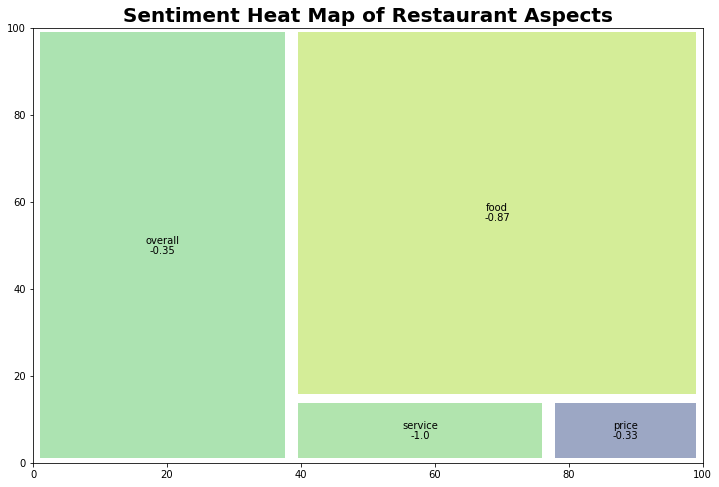

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify

norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
#colors = [matplotlib.cm.Reds(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
#squarify.plot(label=df_summary.category,sizes=df_summary.buzz, color = colors, alpha=.5, pad =True)
# As an exercise, use a colormap intensity to reflect the sentiment value. 
squarify.plot(label=df_summary.category,sizes=df_summary.buzz, value = df_summary.sentiment,alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Restaurant Aspects",fontsize=20,fontweight="bold")

### Conclusion
This example illustrates how the reviews are categorised and sentiment classified based on 3 aspect categories - food, price and service, with the rest as others.

There are many ways to improve on it. This includes using:
 - stemming to identify mapped words
 - integrating with consistency parsing to obtain noun chunks
 - Other ways to improve on it is to fine-tine the training set, like using negation etc and also using co-reference resolution. The latter is useful as many of the pronouns like 'it', 'they'  have no identified targets in the subsequent sentences. They should similarly be mapped to the relevant entities and aspects.

### Exercise

- Perform the same exercise on another set of data - this time for rows of the airline sentiment data in the previous exercise. What are the difficulties that you face? What aspects (and groups) do you consider in this case (heuristically)?